# Neural Network, Task 2

### Importing the dataset



In [3]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


In [4]:
mnist = fetch_openml('mnist_784')
X, y = mnist["data"], mnist["target"]

X = X/255
X = X.astype('float32')

print(X.shape)
print(y.shape)

def one_hot(y, cat, dtype=np.float32):
    return np.array(y[:, None] == np.arange(cat), dtype)
y_new = one_hot(y.astype('int32'), 10)

# Splitting Dataset
split = 60000

X_train = X[:split]
y_train = y_new[:split]

X_test = X[split:]
y_test = y_new[split:]

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

(70000, 784)
(70000,)
X_train:  (60000, 784)
y_train:  (60000, 10)
X_test:  (10000, 784)
y_test:  (10000, 10)


### Making the Neural Network class.

We made the neural network class. We have only one class, we tried different methods of refactoring the idea was to:

- make different classes for different optimizers
- make different classed for different loss functions 
- combine the functionality on the Task2 class and pass them to the other classes to provide the functionality required. 

However, we did try those methods, but when we tried to refactore it we found that the code was not working properly, and we did not have enough time to implement it. Therefore we decided to leave what was working. 

#### Reflexion

Making the classes we wanted to do takes a lot of thinking about the design of the architecture, such as what to use as parameters, how to link different classes between each other and how to call the different methods and what design patterns to use.



In [7]:
class Task2(object):
    
    def __init__(self, layers, act_func, epochs, learn_r):
        self.layers = layers        # List of nodes in each layer
        self.epochs = epochs        # Number of Epochs 
        self.learn_r = learn_r      # Learning rate applied to optimizer
        
        self.Errors = []            # List to keep track of errors calculated
        self.Epochs = []            # List to keep track of iterations 
        self.Loss = []              # List to keep track of loss throughout training
        self.Cost = []              # List to keep track of loss throughout training
        
        self.func  = act_func                                     # Activation function chosen 
        self.funcs = {'sigmoid': self.sigmoid, 'relu': self.relu} # Dictionary to correpond to chosen activation funciton
        
        # dictionary to keep track of weights
        self.network = self.instantiate()   

# Sigmoid function to be applied to input/hidden layers 
# Output 1 as x -> +∞ | 0 as x -> -∞
    def sigmoid(self, z, isDeriv):
        if isDeriv: # When backpropagating
            return (np.exp(-z)) / ((np.exp(-z) + 1 )**2)
        
        return 1 / (1 + np.exp(-z)) # Forward feed
    
# Relu function can also be applied to input/hidden layers
    def relu(self, z, isDeriv):
        t = np.ones((len(z))) 
        if isDeriv: 
            for i in range(len(z)):
                if z[i] >= 0:
                    t[i] = 1
                else:
                    t[i] = 0
            return t
        
        r = np.maximum(0, z)
        return r
    
# Softmax function to be applied to the output layer 
    def softmax(self, z, isDeriv):
        expo = np.exp(z - z.max())
        
        if isDeriv: # When backpropagating
            return expo / np.sum(expo, axis=0) * (1 - expo / np.sum(expo, axis=0))
        
        return expo / np.sum(expo, axis = 0) # Forward feed
    
    def cross_entropy(self, ytrain, output):
        L_sum = np.sum(np.multiply(ytrain, np.log(output)))
        L = -(1/ytrain.shape[0]) * L_sum        # L = -(1/m) . sum (y . log y^)
        return L
    
    def instantiate(self):
        
        # Input Layer, Hidden Layer, Hidden Layer, Output Layer
        inputLayer = self.layers[0]
        hiddenLayer = self.layers[1]
        hiddenLayer2 = self.layers[2]
        outputLayer = self.layers[3]
        
        network = {
                    'W1' : np.random.randn(hiddenLayer, inputLayer) * np.sqrt(1.0/hiddenLayer),     # Weight for Input -> Hidden 1
                    'W2' : np.random.randn(hiddenLayer2, hiddenLayer) * np.sqrt(1.0/hiddenLayer2),  # Weight for hidden 1 -> Hidden 2
                    'W3' : np.random.randn(outputLayer, hiddenLayer2) * np.sqrt(1.0/outputLayer)   # Weight for Hidden 2 -> Output
                    
                    #,'b1' : np.zeros((hiddenLayer, 1)) * np.sqrt(1.0/inputLayer),                    # Bias used in W1
                    #'b2' : np.zeros((hiddenLayer2, 1)) * np.sqrt(1.0/hiddenLayer),                  # Bias used in W2
                    #'b3' : np.zeros((outputLayer, 1)) * np.sqrt(1.0/hiddenLayer2)                   # Bias used in W3
                    
                  }

        return network

    def forward(self, X_train):
        
        network = self.network
        f = self.func   # Activation function chosen
        fs = self.funcs # Dictionary of activation functions
        
        # Input Layer
        network['A0'] = X_train
        
        # Input -> Hidden
        network['Z1'] = np.dot(network["W1"], network['A0']) #+ network['b1']
        network['A1'] = fs[f](network['Z1'], isDeriv = False)
        
        # Hidden Layer 1 -> Hidden Layer 2
        network['Z2'] = np.dot(network["W2"], network['A1']) #+ network['b2']
        network['A2'] = fs[f](network['Z2'], isDeriv = False)

        # Hidden Layer 2 -> Output
        network['Z3'] = np.dot(network["W3"], network['A2']) #+ network['b3']
        network['A3'] = self.softmax(network['Z3'], isDeriv = False)

        return network['A3']    # Return output

    def backward(self, y_train, output):
        
        update = {}                 # Dictionary to hold changes to weights 
        network = self.network        
        Errors = self.Errors
        Loss = self.Loss        
        f = self.func                
        fs = self.funcs             
        
        # Error: subtract target array from the output of a forward propagation
        loss = self.cross_entropy(y_train, output)
        Loss.append(loss)
        
        # Update from Softmax Output 
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(network['Z3']
                                                                    , isDeriv = True)
        Errors.append(error)
        update['W3'] = np.outer(error, network['A2'])
        
        # Update Hidden Layer 2                  ↓ Call activation function from dictionary
        error = np.dot(network['W3'].T, error) * fs[f](network['Z2']
                                                   , isDeriv = True)
        Errors.append(error)
        update['W2'] = np.outer(error, network['A1'])

        # Update from Hidden Layer 1             ↓ Call activation function from dictionary
        error = np.dot(network['W2'].T, error) * fs[f](network['Z1'], isDeriv = True)
        Errors.append(error)       
        update['W1'] = np.outer(error, network['A0'])

        return update        # Return updated dictionary 

    def optimizer(self, gradient):
        # Stochastic Gradient Descent
        for theta, grad in gradient.items():
            self.network[theta] -= self.learn_r * grad

    def accuracy(self, X_test, y_test):
        predict = []
        
        for x, y in zip(X_test, y_test):
            output = self.forward(x)                # Forward feed
            pred = np.argmax(output)                # Return index of max value in output
            predict.append(pred == np.argmax(y))    # Add highest predicted value to list
            mean = np.mean(predict)                 # Calculate mean of values in list
        
        return mean        # Return overall accuracy 

    def train_network(self, X_train, y_train, X_test, y_test):
        
        for i in range(self.epochs):                
            for x,y in zip(X_train, y_train):
                output = self.forward(x)
                gradient = self.backward(y, output)
                self.optimizer(gradient)
                self.Epochs.append(i)
            
            accuracy = self.accuracy(X_test, y_test)
            print("Epoch: ", i + 1, " - Accuracy: ", accuracy * 100, "%")


### Trainig and Testing the Neural Network.

We used the train_network method to train the network.

In [6]:
NN = Task2(  layers = [784, 256, 128, 10], act_func = 'sigmoid',
             epochs = 10, learn_r = 0.01)

NN.train_network(X_train, y_train, X_test, y_test)

Epoch:  1  - Accuracy:  69.37 %
Epoch:  2  - Accuracy:  79.64 %
Epoch:  3  - Accuracy:  81.64 %
Epoch:  4  - Accuracy:  82.44 %
Epoch:  5  - Accuracy:  88.29 %
Epoch:  6  - Accuracy:  87.39 %
Epoch:  7  - Accuracy:  86.78 %
Epoch:  8  - Accuracy:  86.86 %
Epoch:  9  - Accuracy:  87.16000000000001 %
Epoch:  10  - Accuracy:  86.79 %


### Plotting the results

WE are going to plot how the loss function changes as the number of Epochs is increased.

Text(0, 0.5, 'Loss')

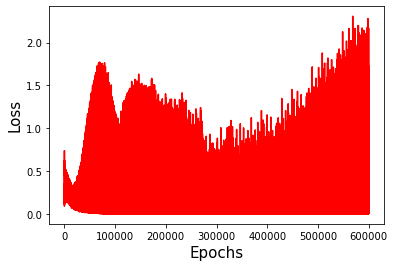

In [8]:
########################################
#               PLOTTING               #
########################################

# Calculated Loss over every iteration
losses = NN.Loss
#print(losses)

plt.plot(losses, 'r-')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

